# Challenge: Factors that affect life expectancy


Throughout this module, we dove deep into the topics of exploratory data analysis (EDA) and its substeps. Now it's time to apply your knowledge. In this challenge, you'll work with the [Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who/home) from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'lifeexpectancy'<br>
table_name = 'lifeexpectancy'<br>

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

* Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

* First, load the dataset.

* Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them. 

* Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

* In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

* Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()
lifeexpectancy_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [2]:
# Find number of rows and columns in the data frame as well as the data type of each column
lifeexpectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

As we can see from the output, this dataset contains 2,938 observations and 22 columns. It appears that only the Country and Status fields are objects (which means that they are strings).

Also this data set is time-series dataset. Our target/outcome variable is Life Expectancy. 

In [3]:
# Strip column names from whitespace
col_names = {k:k.replace(k,k.strip()) for k in lifeexpectancy_df.columns}
lifeexpectancy_df.rename(columns=col_names,inplace=True)

In [4]:
lifeexpectancy_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [5]:
# If there are any infinite values in the dataframe then replace with NaN values

lifeexpectancy_df = lifeexpectancy_df.replace([np.inf, -np.inf], np.nan) 

In [6]:
lifeexpectancy_df.nunique()

Country                             193
Year                                 16
Status                                2
Life expectancy                     362
Adult Mortality                     425
infant deaths                       209
Alcohol                            1076
percentage expenditure             2328
Hepatitis B                          87
Measles                             958
BMI                                 608
under-five deaths                   252
Polio                                73
Total expenditure                   818
Diphtheria                           81
HIV/AIDS                            200
GDP                                2490
Population                         2278
thinness  1-19 years                200
thinness 5-9 years                  207
Income composition of resources     625
Schooling                           173
dtype: int64

In [7]:
lifeexpectancy_df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

*It seems like we have most of missing values in Population, GDP, Hepatitis B, Total expenditure*

In [8]:
# Check the rows with NaN values

lifeexpectancy_df[lifeexpectancy_df.isna().any(axis=1)]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
32,Algeria,2015,Developing,75.6,19.0,21,NaN,0.000000,95.0,63,...,95.0,NaN,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4
37,Côte d'Ivoire,2001,Developing,47.8,467.0,65,3.15,0.000000,1.0,5790,...,7.0,4.85,66.0,7.0,NaN,NaN,7.9,7.9,NaN,NaN
45,Algeria,2003,Developing,71.7,146.0,20,0.34,25.018523,NaN,15374,...,87.0,3.60,87.0,0.1,294.335560,3243514.0,6.3,6.1,0.663,11.5
46,Algeria,2002,Developing,71.6,145.0,20,0.36,148.511984,NaN,5862,...,86.0,3.73,86.0,0.1,1774.336730,3199546.0,6.3,6.2,0.653,11.1
47,Algeria,2001,Developing,71.4,145.0,20,0.23,147.986071,NaN,2686,...,89.0,3.84,89.0,0.1,1732.857979,31592153.0,6.4,6.3,0.644,10.9
48,Algeria,2000,Developing,71.3,145.0,21,0.25,154.455944,NaN,0,...,86.0,3.49,86.0,0.1,1757.177970,3118366.0,6.5,6.4,0.636,10.7
49,Angola,2015,Developing,52.4,335.0,66,NaN,0.000000,64.0,118,...,7.0,NaN,64.0,1.9,3695.793748,2785935.0,8.3,8.2,0.531,11.4
58,Angola,2006,Developing,47.7,381.0,90,5.84,25.086888,NaN,765,...,36.0,4.54,34.0,2.5,262.415149,2262399.0,9.8,9.7,0.439,7.2
59,Angola,2005,Developing,47.4,382.0,92,5.04,98.191451,NaN,258,...,39.0,4.10,38.0,2.6,1443.991929,19552542.0,1.0,9.9,0.426,6.8
60,Angola,2004,Developing,47.1,386.0,94,3.53,8.866777,NaN,29,...,4.0,4.71,4.0,2.5,141.868440,18865716.0,1.2,1.1,0.415,6.4


#### Let's see which variables correlate the most with Life expectancy ####

In [9]:
correlation = lifeexpectancy_df.corr()
correlation = correlation.sort_values(by=['Life expectancy'],ascending=False)

correlation[['Life expectancy']]


,Life expectancy
Life expectancy,1.000000
Schooling,0.751975
Income composition of resources,0.724776
BMI,0.567694
Diphtheria,0.479495
Polio,0.465556
GDP,0.461455
Alcohol,0.404877
percentage expenditure,0.381864
Hepatitis B,0.256762


*Schooling and Income composition of resources shows strong positive correlation, whereas Adult Mortality and HIV/AIDS shows strong negative correlation with the Life expectancy. This represents that the Schooling and Income composition of resources increases with Life Expectancy for countries.*


In [10]:
# Let's calculate the percentages of the missing values in all columns:

lifeexpectancy_df.isnull().sum()*100/lifeexpectancy_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness  1-19 years                1.157250
thinness 5-9 years                  1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

In [11]:
#Lets check the Status Counts
lifeexpectancy_df.Status.value_counts()

Developing    2426
Developed      512
Name: Status, dtype: int64

In [12]:
lifeexpectancy_df_orig = lifeexpectancy_df.copy()

##### Define Functions to fill the mean values and visualize the missing data and outliers #####

In [13]:
from scipy.stats import zscore
import numpy as np

# Function to fill mean value for each column
def fillna_mean (df, column_name):

    return df[column_name].fillna(df[column_name].mean(), inplace=True)

# function to fill mean values for all specified columns in the list:
def fillna_mean_columns(df, col_list):

    for col in col_list:
    
        fillna_mean(df, col)

# Print Z-scores for a specified column
def print_zscore(df, col_list):
    
    for col in col_list:
        print(col)
        z_scores = zscore(df[col])
        for threshold in range(1,5):
            print("The score threshold is: {}".format(threshold))
            print("The indices of the outliers:")
            print(np.where(z_scores > threshold))
            print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))
        

# Function t0 visualize the data
def visualize_missing_data (orig_df, df, column_name):
        df_log = df
        
        plt.figure(figsize=(15,3)) 
        
        # histograms of the original data
        plt.subplot(1, 3, 1)
        plt.hist(orig_df[column_name])
        plt.title("histogram of {} (original)".format(column_name))

        # histograms of the mean values 
        plt.subplot(1, 3, 2)
        plt.hist(df[column_name])
        plt.title("histogram of {} (Mean)".format(column_name))
        

        # histograms of the interpolated data
        plt.subplot(1, 3, 3)
        plt.hist(df[column_name].interpolate())
        plt.title("histogram of {} (interpolated)".format(column_name))
        
        plt.show()

# Function t0 visualize the data
def visualize_outliers (orig_df, df, column_name):
        df_log = df
        
        plt.figure(figsize=(15,3)) 
        
        # histograms of the original data
        plt.subplot(1, 3, 1)
        plt.hist(orig_df[column_name])
        plt.title("histogram of {} (original)".format(column_name))

        # histograms of the log transformed data
        plt.subplot(1, 3, 2)
        df[column_name] = [0 if x == 0 else np.log(x) for x in df[column_name]] # added this to fix the finite issue
        plt.hist(df[column_name])
        plt.title("histogram of {} (log transformed)".format(column_name))

        
        # histograms of the winsorized data
        winsorized_column = "winsorized_" + column_name
        plt.subplot(1, 3, 3)
        df[winsorized_column] = winsorized_views = winsorize(df[column_name], (0.05, 0.10))
        plt.hist(df[winsorized_column])
        plt.title("histogram of {} (winsorized)".format(column_name))
        
        plt.show()

In [14]:
lifeexpectancy_df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [15]:
cols = ["Diphtheria", "Adult Mortality", "Alcohol", "Hepatitis B", "BMI", "Polio", "Total expenditure", "HIV/AIDS", "GDP", "Population", "Income composition of resources", "Schooling"]
analyze_cols = ["Adult Mortality", "HIV/AIDS", "Income composition of resources", "Schooling"]
# Fill in mean values for missing data
fillna_mean_columns(lifeexpectancy_df,cols)

In [16]:
 # print ZScores
print_zscore(lifeexpectancy_df,analyze_cols)

Adult Mortality
The score threshold is: 1
The indices of the outliers:
(array([   8,    9,   10,   11,   12,   14,   15,   37,   49,   50,   51,
         52,   53,   54,   55,   56,   57,   58,   59,   60,   61,   62,
        304,  341,  342,  343,  344,  345,  346,  347,  348,  349,  350,
        351,  352,  409,  411,  412,  413,  414,  415,  416,  418,  420,
        421,  423,  425,  426,  427,  428,  429,  430,  431,  432,  433,
        435,  436,  437,  438,  439,  440,  441,  442,  443,  444,  445,
        446,  447,  480,  481,  482,  483,  484,  486,  487,  488,  489,
        491,  492,  495,  512,  513,  514,  515,  516,  517,  518,  519,
        520,  522,  523,  528,  529,  530,  531,  532,  533,  535,  536,
        537,  613,  614,  615,  616,  617,  618,  620,  621,  622,  623,
        727,  728,  729,  731,  732,  733,  734,  736,  760,  761,  763,
        764,  765,  766,  767,  768,  837,  838,  839,  840,  842,  843,
        844,  845,  846,  847,  848,  849,  850,  85

We notice that the outliers decreases as the threshold increases.

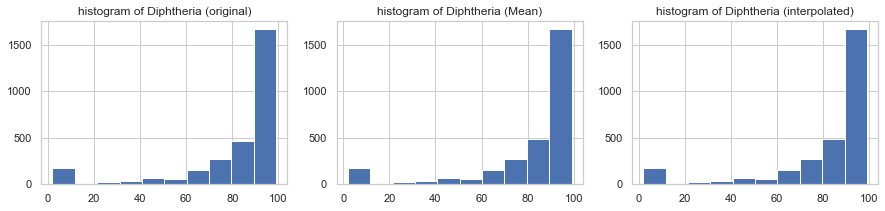

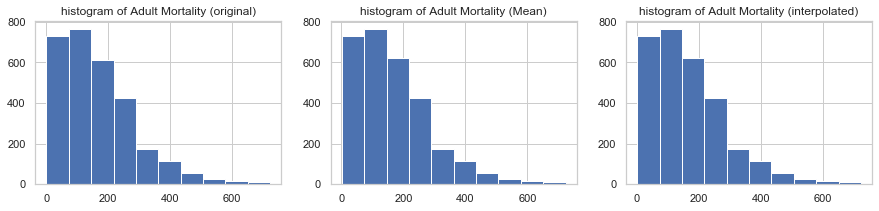

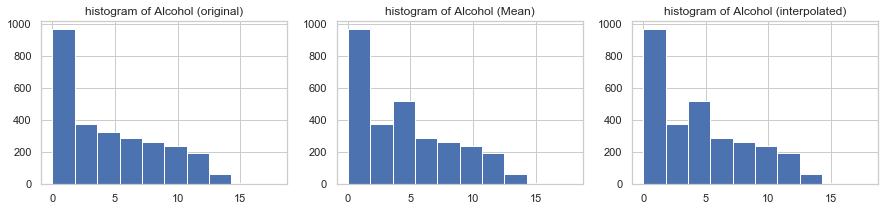

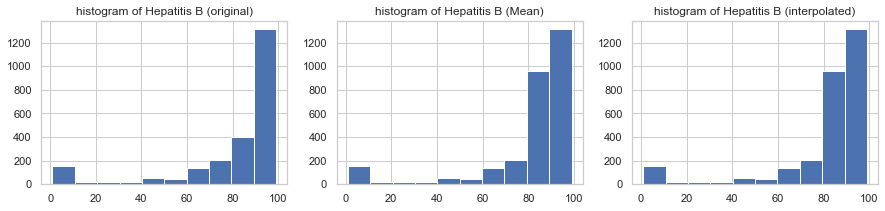

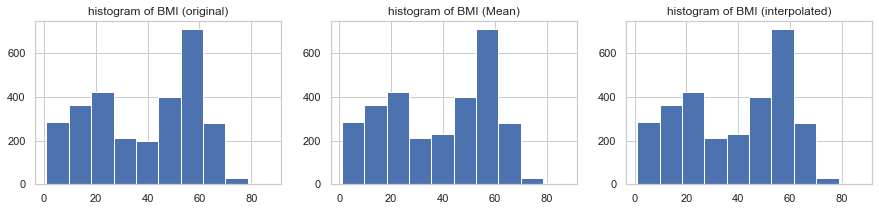

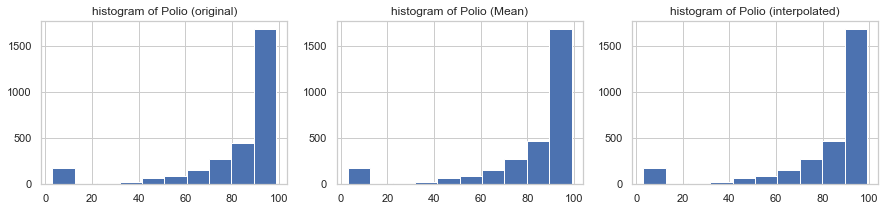

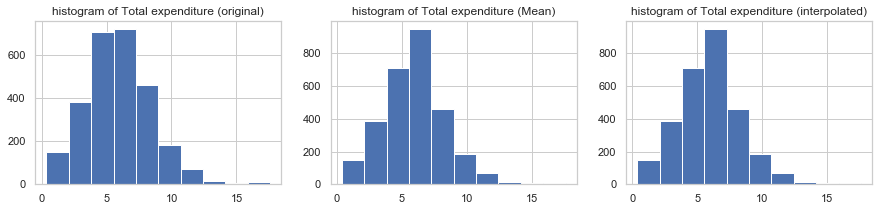

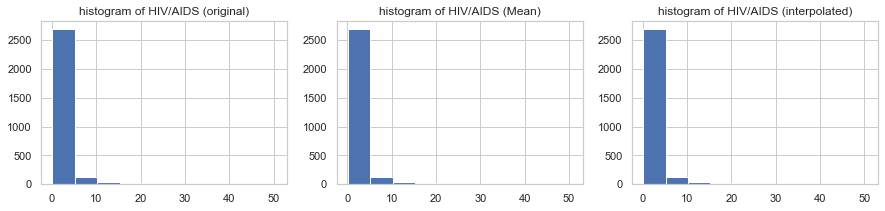

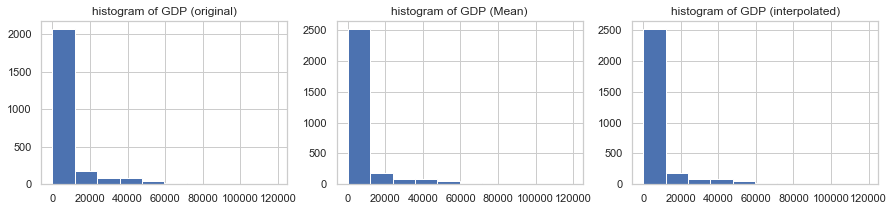

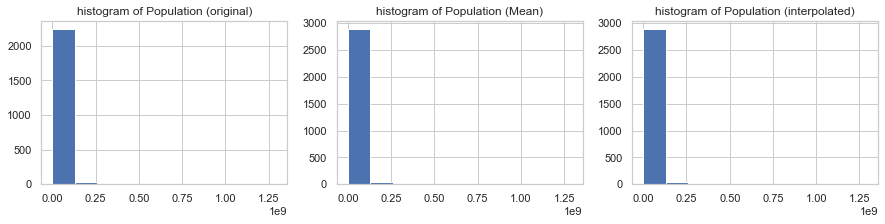

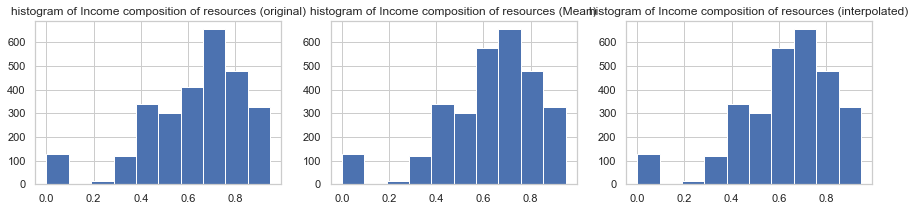

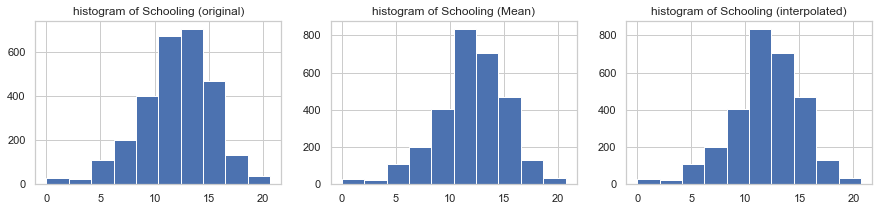

In [17]:
    for col in cols:
        visualize_missing_data(lifeexpectancy_df_orig, lifeexpectancy_df,col)

Based on the visualization above, the original data with missing values, (or) the data filled with mean values (or) application of interpolation did not change the data itself.

#### Let us do outlier analysis. ####

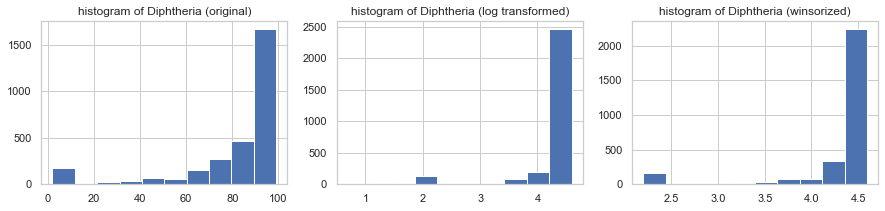

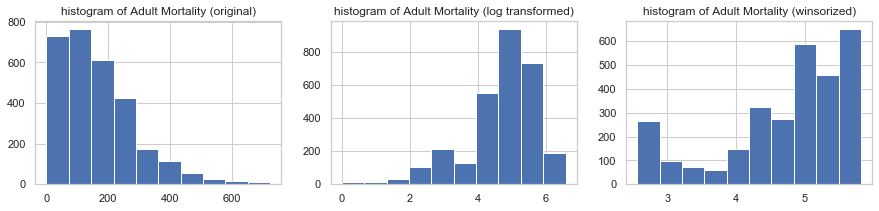

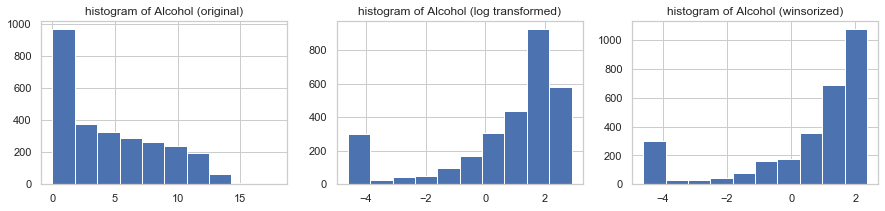

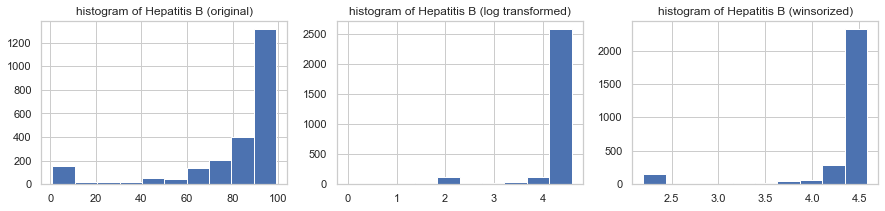

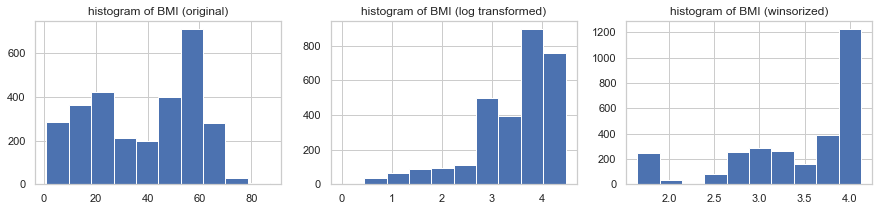

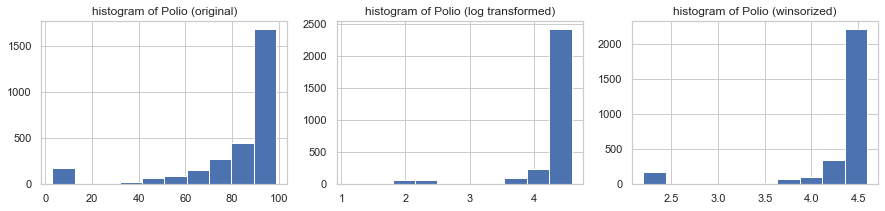

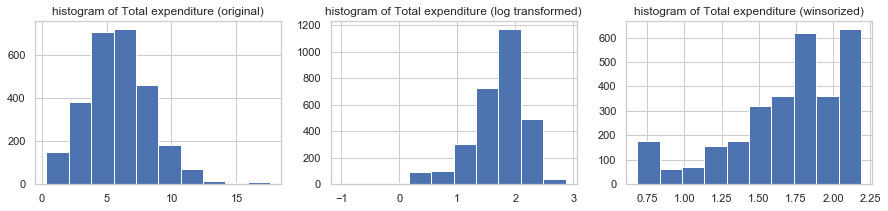

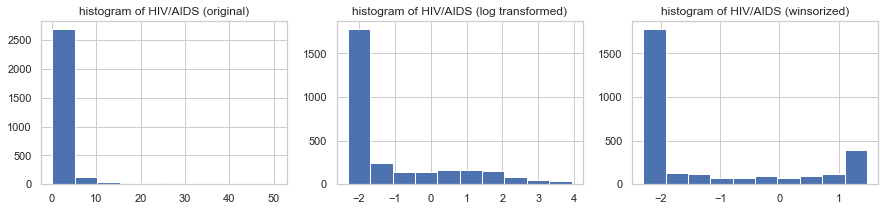

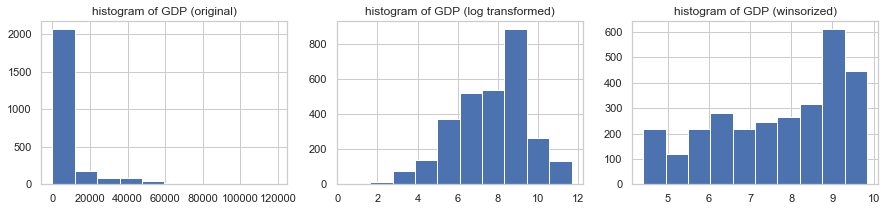

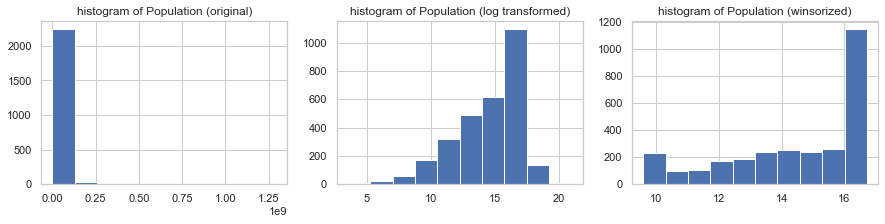

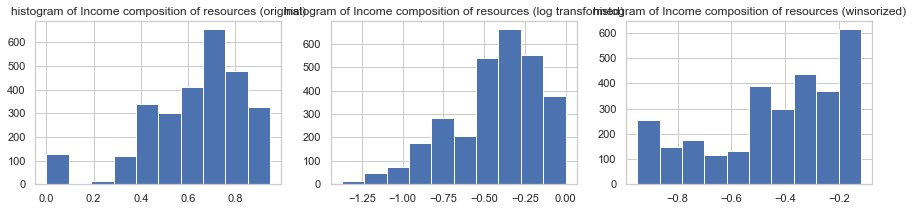

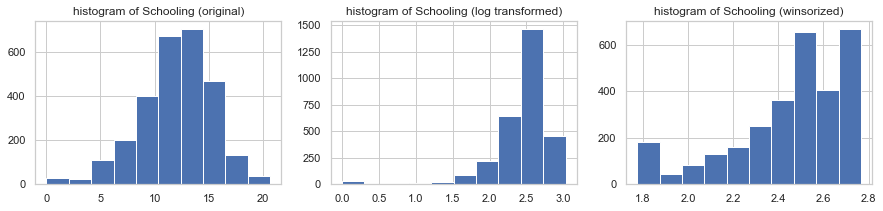

In [18]:
for col in cols:
        visualize_outliers(lifeexpectancy_df_orig, lifeexpectancy_df, col)

It seems like the log transformation normalizes the data set, therefore we can apply either winsorization or log transformation method to treat the outliers.

In [19]:
# Get descriptive statistics

lifeexpectancy_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,winsorized_Alcohol,winsorized_Hepatitis B,winsorized_BMI,winsorized_Polio,winsorized_Total expenditure,winsorized_HIV/AIDS,winsorized_GDP,winsorized_Population,winsorized_Income composition of resources,winsorized_Schooling
count,2938.000000,2928.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.224932,4.709236,30.303948,0.559493,738.251295,4.289955,2419.592240,3.416440,42.035739,...,0.546875,4.300447,3.436010,4.318305,1.686077,-1.305812,7.658670,14.421373,-0.432762,2.450317
std,4.613841,9.523867,1.072350,117.926501,2.108834,1987.914858,0.603932,11467.272489,0.806915,160.445548,...,2.097379,0.555412,0.729128,0.565702,0.402384,1.423924,1.604072,2.226658,0.250154,0.264290
min,2000.000000,36.300000,0.000000,0.000000,-4.605170,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.605170,2.197225,1.648659,2.197225,0.683097,-2.302585,4.402857,9.587200,-0.949331,1.774952
25%,2004.000000,63.100000,4.304065,0.000000,0.088461,4.685343,4.393714,0.000000,2.965273,0.000000,...,0.088461,4.393714,2.965273,4.356709,1.474763,-2.302585,6.363865,12.945428,-0.590591,2.332144
50%,2008.000000,72.100000,4.969813,3.000000,1.425515,64.912906,4.465908,17.000000,3.761200,4.000000,...,1.425515,4.465908,3.761200,4.532599,1.781404,-2.302585,8.044485,15.117310,-0.379797,2.493205
75%,2012.000000,75.700000,5.424950,22.000000,2.000128,441.534144,4.564348,360.250000,4.027136,28.000000,...,2.000128,4.564348,4.027136,4.574711,1.991976,-0.223144,8.920410,16.361307,-0.233194,2.646175
max,2015.000000,89.000000,6.583409,1800.000000,2.883123,19479.911610,4.595120,212183.000000,4.469350,2500.000000,...,2.362739,4.584967,4.123903,4.595120,2.187174,1.481605,9.840811,16.722117,-0.119910,2.766319


In [20]:
# Make a copy of lifeexpectancy_df
lifeexpectancy_df_winsorized = lifeexpectancy_df.copy()


In [21]:
# Drop unnecessary attibutes
lifeexpectancy_df = lifeexpectancy_df.drop(labels = ["winsorized_Adult Mortality","winsorized_Alcohol","winsorized_Hepatitis B","winsorized_BMI","winsorized_Polio", "winsorized_Total expenditure", "winsorized_GDP", "winsorized_Population","winsorized_Diphtheria", "winsorized_HIV/AIDS",
 "winsorized_Income composition of resources", "winsorized_Schooling"], axis = 1)

lifeexpectancy_df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

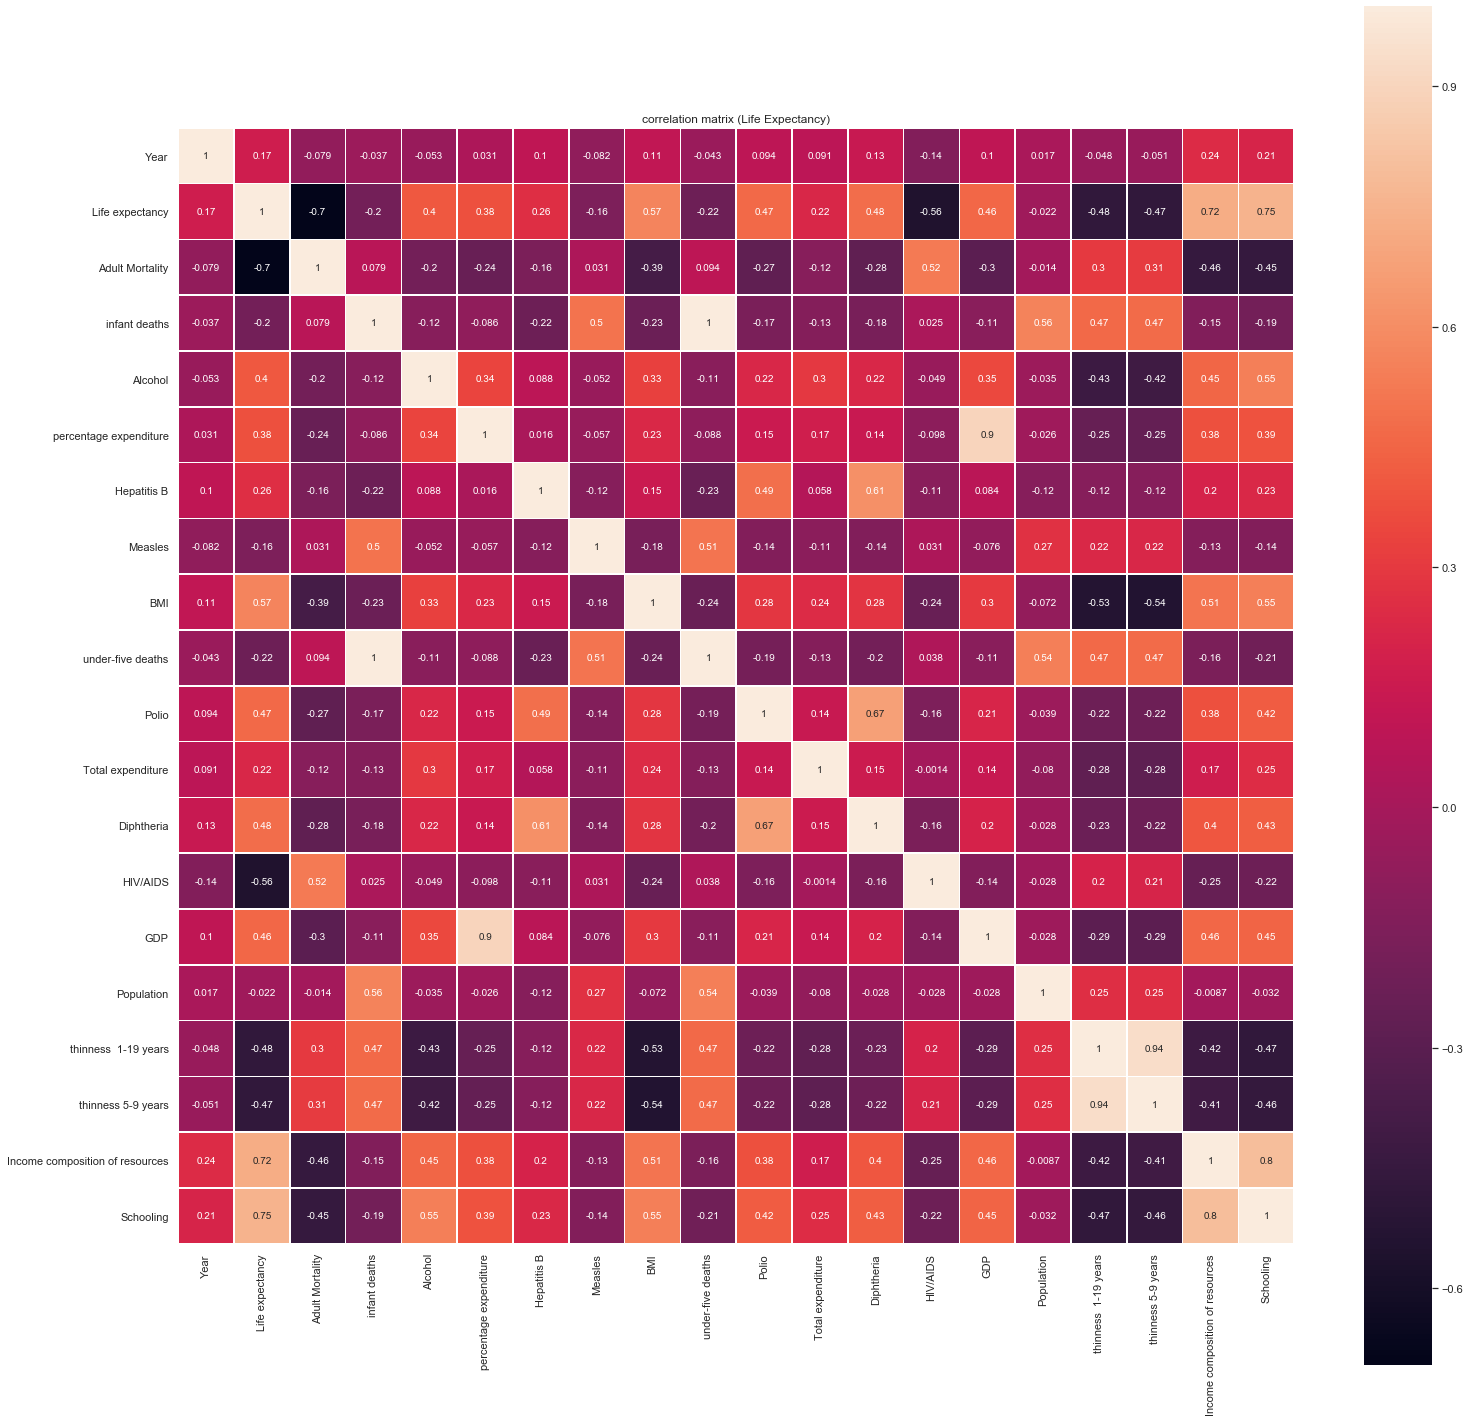

In [22]:
# make the correlation matrice.
corrmat = lifeexpectancy_df_orig.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(25,25))

# draw the heatmap using seaborn.
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Life Expectancy)")


plt.show()



#### Highly Correlated features:#### 

- GDP and percent expenditure (0.9)
- diphitheria and polio (0.67)
- life expectancy and income (0.78)
- life expectancy and schooling (0.69)

#### Strong Positively Correlated features with Life Expectancy:#### 

- Schooling (0.75)
- Income composition of resources (0.72)

#### Strong Negatively Correlated features with Life Expectancy:#### 

- Adult Mortality (-0.70)
- HIV/AIDS (-0.56)

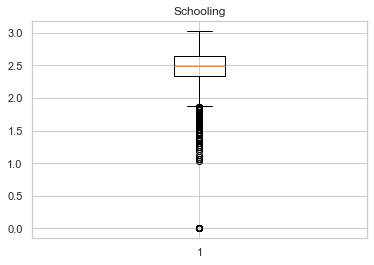

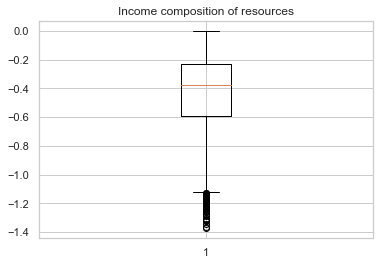

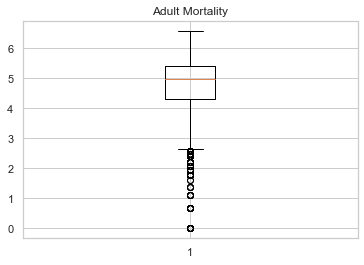

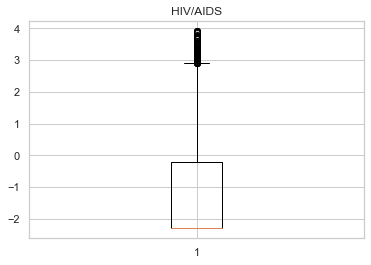

In [23]:
# Plot each of the 4 variables that are strongly correlated with Life Expectancy and to check the outliers
plt.boxplot(lifeexpectancy_df['Schooling'])
plt.title('Schooling')
plt.show()
plt.boxplot(lifeexpectancy_df['Income composition of resources'])
plt.title('Income composition of resources')
plt.show()
plt.boxplot(lifeexpectancy_df['Adult Mortality'])
plt.title('Adult Mortality')
plt.show()
plt.boxplot(lifeexpectancy_df['HIV/AIDS'])
plt.title('HIV/AIDS')
plt.show()

In [24]:
# Let us treat the outlier by winsorizing the variables in order to get a smaller range.
lifeexpectancy_df['Schooling'] = winsorize(lifeexpectancy_df['Adult Mortality'],limits=[0.05,.10]) 
lifeexpectancy_df['Income composition of resources'] = winsorize(lifeexpectancy_df['HIV/AIDS'],limits=[0.05,.10])
lifeexpectancy_df['Adult Mortality'] = winsorize(lifeexpectancy_df['Adult Mortality'],limits=[0.05,.10]) 
lifeexpectancy_df['HIV/AIDS'] = winsorize(lifeexpectancy_df['HIV/AIDS'],limits=[0.05,.10])

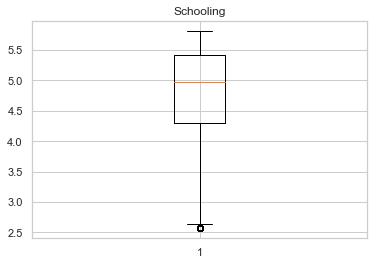

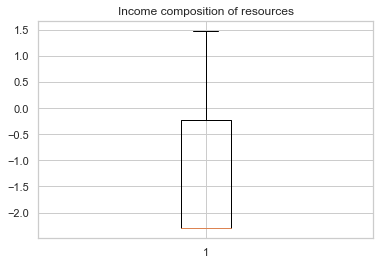

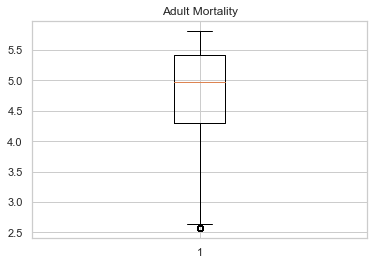

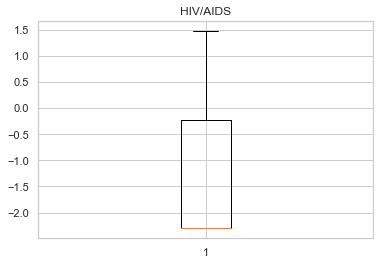

In [25]:
# Re-plot the variables with outliers
plt.boxplot(lifeexpectancy_df['Schooling'])
plt.title('Schooling')
plt.show()
plt.boxplot(lifeexpectancy_df['Income composition of resources'])
plt.title('Income composition of resources')
plt.show()
plt.boxplot(lifeexpectancy_df['Adult Mortality'])
plt.title('Adult Mortality')
plt.show()
plt.boxplot(lifeexpectancy_df['HIV/AIDS'])
plt.title('HIV/AIDS')
plt.show()

### Perform Univariate Analysis ###

Let us perform univariate analysis by exploring their values and variance of the chosen variables, as well as plotting their distribution.

In [26]:
# Schooling correlation variable
correlation = lifeexpectancy_df.corr()
correlation = correlation.sort_values(by=['Schooling'], ascending=False)

correlation[['Schooling']]

,Schooling
Schooling,1.000000
Adult Mortality,1.000000
HIV/AIDS,0.371480
Income composition of resources,0.371480
thinness 5-9 years,0.228744
thinness 1-19 years,0.218124
under-five deaths,0.062247
infant deaths,0.054137
Population,0.048497
Measles,0.005871


In [27]:
# Income composition of resources 
correlation = lifeexpectancy_df.corr()
correlation = correlation.sort_values(by=['Income composition of resources'], ascending=False)

correlation[['Income composition of resources']]

,Income composition of resources
HIV/AIDS,1.000000
Income composition of resources,1.000000
Schooling,0.371480
Adult Mortality,0.371480
thinness 1-19 years,0.347782
thinness 5-9 years,0.330273
under-five deaths,0.147797
infant deaths,0.119121
Measles,0.109919
Population,0.023104


In [28]:
# Adult Mortality
correlation = lifeexpectancy_df.corr()
correlation = correlation.sort_values(by=['Adult Mortality'], ascending=False)

correlation[['Adult Mortality']]

,Adult Mortality
Schooling,1.000000
Adult Mortality,1.000000
HIV/AIDS,0.371480
Income composition of resources,0.371480
thinness 5-9 years,0.228744
thinness 1-19 years,0.218124
under-five deaths,0.062247
infant deaths,0.054137
Population,0.048497
Measles,0.005871


In [29]:
# HIV/AIDS
correlation = lifeexpectancy_df.corr()
correlation = correlation.sort_values(by=['HIV/AIDS'], ascending=False)

correlation[['HIV/AIDS']]

,HIV/AIDS
HIV/AIDS,1.000000
Income composition of resources,1.000000
Schooling,0.371480
Adult Mortality,0.371480
thinness 1-19 years,0.347782
thinness 5-9 years,0.330273
under-five deaths,0.147797
infant deaths,0.119121
Measles,0.109919
Population,0.023104


### Perform Multivariate Analysis ###

We can perform multivariate analysis by exploring the relationship between the chosen variables Schooling, Income composition of resources, with the target variable Life expectancy.


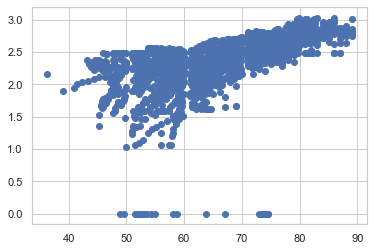

In [30]:
#Let us plot a scatter plot for Schooling and the target variable Life expectancy
plt.scatter(lifeexpectancy_df_winsorized['Life expectancy'] ,lifeexpectancy_df_winsorized['Schooling'], )
plt.show()

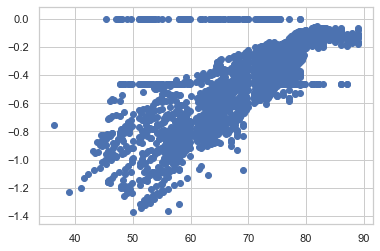

In [31]:
#Let us plot a scatter plot for Income composition of resources and the target variable Life expectancy
plt.scatter(lifeexpectancy_df_winsorized['Life expectancy'] ,lifeexpectancy_df_winsorized['Income composition of resources'], )
plt.show()

*Income Composition of Resources seems to correlate better (more linearly) with Life Expectancy*

## Feature Engineering ##


In the feature engineering step, we need to select a suite of variables that we think would be ideal in the modeling phase. More concretely, we may discard some variables that are very correlated with the other ones or the variables that we think are irrelevant to life expectancy.

In [32]:
# Make a copy of the dataframe
lifeexpectancy_pca = lifeexpectancy_df.copy()

In [33]:
# Drop categorical columns
lifeexpectancy_pca = lifeexpectancy_pca.drop(columns=['Country','Status'])
lifeexpectancy_pca = lifeexpectancy_pca.replace([np.inf, -np.inf], np.nan).dropna()

In [34]:
lifeexpectancy_pca.columns

Index(['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI',
       'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

##### Principal Component Analysis #####

We have a data set of dimension 2,938 observations and 20 predictors. Since we have a 20 predictors, there can be around 150+ scatter plots possible to analyze the variable relationship. It would be tedious job to perform exploratory analysis on this data, therefore we will perform prinicpal component analysis to extract the most important variables.

[97.07 99.97 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99]


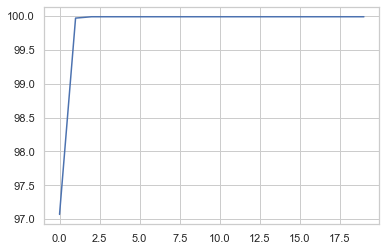

In [35]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline

#Fit Transform
X = lifeexpectancy_pca.values

# PCA 
pca = PCA(n_components=20)
pca.fit_transform(X)

#The amount of variance that each PC explains
var = pca.explained_variance_ratio_

#Cumulative Variance explains
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print (var1)
plt.plot(var1)


*Based on the above plot, 2 PCAs are enough to explain the the variance of the variables*

In [36]:
# PCA 
X = StandardScaler().fit_transform(lifeexpectancy_pca.dropna())
sklearn_pca = PCA(n_components=2,svd_solver='full')
Y_sklearn = sklearn_pca.fit_transform(X)

In [37]:
Y_sklearn[:, 0] #pca1
Y_sklearn[:, 1] #pca2

array([ 1.00799326,  0.89241147,  1.19144067, ..., -2.03250453,
       -2.45359409, -1.51776658])

In [38]:
len(sklearn_pca.components_)

2

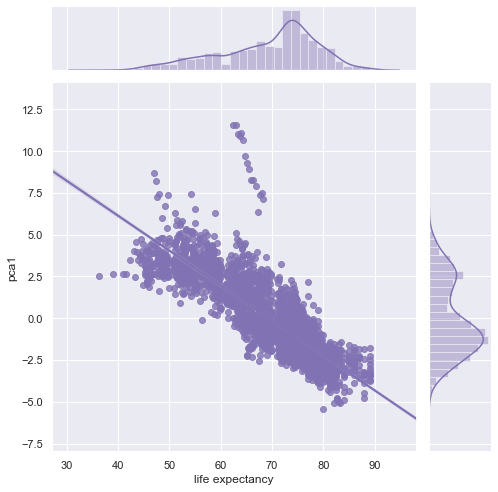

In [39]:
# PCA1 - First PCA component

#temporary dataframe
temp_df = pd.DataFrame({'life expectancy':lifeexpectancy_pca['Life expectancy'],'pca1':Y_sklearn[:, 0],'pca2':Y_sklearn[:, 1]})

sns.set(style="darkgrid")

g = sns.jointplot('life expectancy', "pca1", data=temp_df, kind="reg", color="m", height=7)

*Based on the scatterplot it is clear that there is correlation between pca1 and life expectancy. For example, if pca1 is 0, the life expectancy is between 60 to 70.*

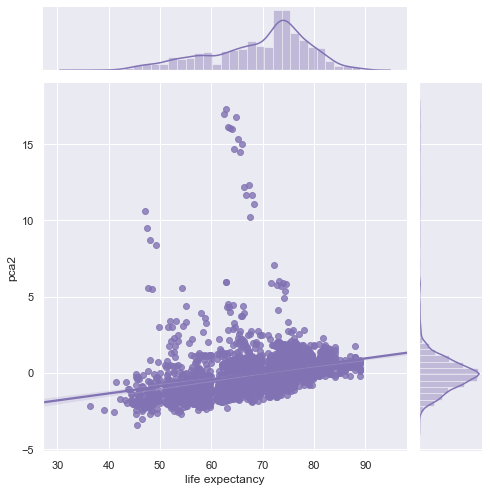

In [40]:
sns.set(style="darkgrid")

g = sns.jointplot('life expectancy', 'pca2', data=temp_df, kind="reg", color="m", height=7)


*From the above plot it is clear that pca2 follows a normal distribution.*

In [41]:
#Let us recover the feature from the PCA

# normalize data
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.scale(lifeexpectancy_pca),columns = lifeexpectancy_pca.columns) 

# PCA
pca = PCA(n_components=2)
pca.fit_transform(data_scaled)

# Dump components relations with features:
print (pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2']))



          Year  Life expectancy  Adult Mortality  infant deaths   Alcohol  \
PC-1 -0.057826        -0.362613         0.227166       0.207481 -0.147241   
PC-2  0.019325         0.174643        -0.273487       0.482502 -0.033660   

      percentage expenditure  Hepatitis B   Measles       BMI  \
PC-1               -0.184197    -0.095930  0.136239 -0.236057   
PC-2                0.082046    -0.030781  0.325089  0.005516   

      under-five deaths     Polio  Total expenditure  Diphtheria  HIV/AIDS  \
PC-1           0.215350 -0.168696          -0.108926   -0.176535  0.320923   
PC-2           0.473651  0.062581          -0.073184    0.061851 -0.233668   

           GDP  Population  thinness  1-19 years  thinness 5-9 years  \
PC-1 -0.252426    0.042611              0.308514            0.308631   
PC-2  0.103767    0.140777              0.216756            0.219067   

      Income composition of resources  Schooling  
PC-1                         0.320923   0.227166  
PC-2              

In [42]:
i = np.identity(lifeexpectancy_pca.shape[1])
coef = pca.transform(i)
pd.DataFrame(coef, columns=['PC-1', 'PC-2'], index=lifeexpectancy_pca.columns)

,PC-1,PC-2
Year,-0.057826,0.019325
Life expectancy,-0.362613,0.174643
Adult Mortality,0.227166,-0.273487
infant deaths,0.207481,0.482502
Alcohol,-0.147241,-0.033660
percentage expenditure,-0.184197,0.082046
Hepatitis B,-0.095930,-0.030781
Measles,0.136239,0.325089
BMI,-0.236057,0.005516
under-five deaths,0.215350,0.473651


The above shows that the first principal component (PC-1) is aligned with Income composition of resources and HIV/AIDS ( both having highest weight of 0.320924)

And second principal component (PC-2) is mostly aligned with infant deaths which has the highest weight of 0.482219 in absolute value.

## Conlcusion: ##

- This dataset contains 2,938 observations and 22 columns. 
- Country and Status fields are categorical whereas all others are continuous variables.
- This data set is time-series dataset with target variable being the Life Expectancy.
- Schooling and Income composition of resources shows strong positive correlation.
- Adult Mortality and HIV/AIDS shows strong negative correlation with the Life expectancy.
- Income Composition of Resources seems to correlate better with Life Expectancy
- There is correlation between pca1 and life expectancy, i.e. when pca1 = 0 then we can say that the life expectancy is between 60 to 70.
- PCA1 is aligned with Income composition of resources and HIV/AIDS ( both having highest weight of 0.320924)
- PCA2 is mostly aligned with infant deaths which has the highest weight of 0.482219 in absolute value.